<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°08

**Objetivo**: Aplicar técnicas de **machine learning no supervisado** para explorar, procesar y analizar conjuntos de datos con variables numéricas y categóricas.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


## Clustering


<img src="https://www.svgrepo.com/show/253022/car.svg" width = "300" align="center"/>



El conjunto de datos **`vehiculos_procesado_con_grupos.csv`** recopila información sobre diversas características relevantes de distintos vehículos. El propósito de este ejercicio es **clasificar los vehículos en diferentes categorías**, utilizando como base las variables descritas en la tabla de atributos.

El análisis presenta un desafío adicional debido a la **naturaleza mixta de los datos**: se incluyen tanto variables **numéricas** (ej. dimensiones, consumo, emisiones) como **categóricas** (ej. tipo de tracción, tipo de combustible), lo que requiere aplicar técnicas de preprocesamiento adecuadas antes de entrenar los modelos.

Como primer paso, procederemos a **cargar y explorar el conjunto de datos**, con el fin de familiarizarnos con su estructura y las características que servirán como base para la posterior clasificación.




**Descripción de los Datos:**

| **Nombre de la Columna**   | **Descripción**                                                                                                                                   |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **year**                   | El año en que el vehículo fue fabricado.                                                                                                          |
| **desplazamiento**          | La capacidad volumétrica del motor en litros. Indica la cantidad de aire y combustible que puede desplazar el motor durante una revolución.       |
| **cilindros**               | El número de cilindros que tiene el motor. Los cilindros son las cámaras donde ocurre la combustión interna en los motores de los vehículos.       |
| **co2**                     | Emisiones de dióxido de carbono del vehículo, medido en gramos por kilómetro. Es una medida de las emisiones de gases de efecto invernadero.       |
| **clase_tipo**              | La clase o tipo de vehículo, como vehículos especiales, deportivos, etc.                                                                         |
| **traccion_tipo**           | Tipo de tracción del vehículo, ya sea tracción en dos ruedas, en cuatro ruedas o en todas las ruedas.                                             |
| **transmision_tipo**        | Tipo de transmisión del vehículo, como automática, manual, entre otros.                                                                          |
| **combustible_tipo**        | Tipo de combustible que utiliza el vehículo, como gasolina, diésel, eléctrico, híbrido, etc.                                                     |
| **tamano_motor_tipo**       | Clasificación del tamaño del motor (por ejemplo, pequeño, mediano o grande), que generalmente se basa en la capacidad de desplazamiento.           |
| **consumo_tipo**            | Clasificación del nivel de consumo de combustible del vehículo, indicando si es alto, bajo, o muy alto.                                           |
| **co2_tipo**                | Clasificación de las emisiones de CO2 del vehículo, indicando si es alto, bajo, o muy alto.                                                       |
| **consumo_litros_milla**    | El consumo de combustible del vehículo, medido en litros por milla. Indica la eficiencia del vehículo en términos de consumo de combustible.        |



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans


%matplotlib inline

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
# cargar datos
df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/vehiculos_procesado_con_grupos.csv", sep=",")\
       .drop(
            ["fabricante",
             "modelo",
             "transmision",
             "traccion",
             "clase",
             "combustible",
             "consumo"],

          axis=1)

df.head()

,year,desplazamiento,cilindros,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,consumo_litros_milla
0,1984,2.5,4.0,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.222671
1,1984,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
2,1985,2.5,4.0,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.236588
3,1985,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
4,1987,3.8,6.0,555.437500,Coches Medianos,dos,Automatica,Premium,grande,alto,alto,0.236588


En este caso, no solo se tienen datos numéricos, sino que también categóricos. Además, tenemos problemas de datos **vacíos (Nan)**. Así que para resolver este problema, seguiremos varios pasos:

### 1.- Normalizar datos

- Cree un conjunto de datos con las variables numéricas, además, para cada dato vacía, rellene con el promedio asociado a esa columna. Finalmente, normalize los datos mediante el procesamiento **MinMaxScaler** de **sklearn**.
- Cree un conjunto de datos con las variables categóricas , además, transforme de variables categoricas a numericas ocupando el comando **get_dummies** de pandas ([referencia](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)). Explique a grande rasgo como se realiza la codificación de variables numéricas a categóricas.

- Junte ambos dataset en uno, llamado **df_procesado**.

In [5]:
#crear conjunto de datos
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

df_num = df[num_cols].copy()

#datos vacios con la media de cada columna
df_num_imputed = df_num.fillna(df_num.mean(numeric_only=True))

#escalar
scaler = MinMaxScaler()
num_scaled = scaler.fit_transform(df_num_imputed)

df_num_proc = pd.DataFrame(num_scaled, columns=num_cols, index=df.index)


# conjunto de datos con las variables categóricas
df_cat = df[cat_cols].copy()

df_cat_proc = pd.get_dummies(df_cat, drop_first=True, dtype=int)

#juntamos datasets
df_procesado = pd.concat([df_num_proc, df_cat_proc], axis=1)

print("Shape original:", df.shape)
print("Shape procesado:", df_procesado.shape)
df_procesado.head()

Shape original: (36791, 12)
Shape procesado: (36791, 29)


,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,clase_tipo_Deportivos,...,tamano_motor_tipo_muy pequeño,tamano_motor_tipo_pequeño,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,0.000000,0.243590,0.142857,0.398014,0.331027,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.000000,0.461538,0.285714,0.527672,0.475113,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0.029412,0.243590,0.142857,0.424351,0.360294,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0.029412,0.461538,0.285714,0.527672,0.475113,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.088235,0.410256,0.285714,0.424351,0.360294,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.- Realizar ajuste mediante kmeans

Una vez depurado el conjunto de datos, es momento de aplicar el algoritmo de **kmeans**.

1. Ajuste el modelo de **kmeans** sobre el conjunto de datos, con un total de **8 clusters**.
2. Asociar a cada individuo el correspondiente cluster y calcular valor de los centroides de cada cluster.
3. Realizar un resumen de las principales cualidades de cada cluster. Para  esto debe calcular (para cluster) las siguientes medidas de resumen:
    * Valor promedio de las variables numérica
    * Moda para las variables numericas

In [7]:
#ajustamos modelo KMeans con 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
kmeans.fit(df_procesado)

#asignar el cluster correspondiente a cada observación
df['cluster'] = kmeans.labels_

#calcular centroides de cada cluster
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=df_procesado.columns)
print("Centroides de los clusters:\n")
display(centroides.head())

#resumen de clusters
resumen_clusters = pd.DataFrame()

for i in range(8):
    grupo = df[df['cluster'] == i]
    print(f"\nCluster {i}: {len(grupo)} vehículos")

    #promedio para numéricas
    resumen_num = grupo.select_dtypes(include=['float64', 'int64']).mean()
    #moda para categóricas
    resumen_cat = grupo.select_dtypes(exclude=['float64', 'int64']).mode().iloc[0]

    resumen = pd.concat([resumen_num, resumen_cat], axis=0)
    resumen_clusters[f'Cluster {i}'] = resumen

display(resumen_clusters)

Centroides de los clusters:



,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,clase_tipo_Deportivos,...,tamano_motor_tipo_muy pequeño,tamano_motor_tipo_pequeño,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,0.451659,0.238421,0.177987,0.304232,0.226257,0.103530,0.049583,0.153511,0.357200,0.172352,...,0.310988,0.460333,9.859183e-01,-5.440093e-15,1.551537e-14,1.408171e-02,9.912733e-01,8.528362e-03,-1.679212e-14,1.983340e-04
1,0.568688,0.168773,0.145300,0.241157,0.156687,0.117846,0.017589,0.139223,0.629549,0.078474,...,0.754566,0.217968,-1.681988e-14,1.352997e-04,-1.035283e-14,9.986470e-01,5.006088e-03,5.411988e-04,8.215650e-15,9.932350e-01
2,0.576884,0.360765,0.298904,0.354767,0.283137,0.086086,0.078023,0.194018,0.564109,0.069961,...,0.051495,0.164889,1.820546e-03,9.973992e-01,1.323941e-14,2.600780e-04,7.494005e-16,9.828349e-01,-9.298118e-15,-1.601497e-14
3,0.313071,0.548444,0.383841,0.507836,0.453114,0.001971,0.016203,0.017955,0.031531,0.132253,...,0.000876,0.011605,-1.404432e-14,1.554312e-15,1.000000e+00,-6.550316e-15,7.494005e-16,-1.160183e-14,1.000000e+00,-1.751377e-14
4,0.405352,0.331349,0.256734,0.354443,0.282215,0.084077,0.090849,0.135613,0.185332,0.171622,...,0.048893,0.219689,1.106706e-02,9.841427e-01,7.438494e-15,4.790221e-03,-1.704192e-14,9.988437e-01,-6.022960e-15,-1.609823e-15



Cluster 0: 5042 vehículos

Cluster 1: 7391 vehículos

Cluster 2: 3845 vehículos

Cluster 3: 4567 vehículos

Cluster 4: 6054 vehículos

Cluster 5: 2769 vehículos

Cluster 6: 3795 vehículos

Cluster 7: 3328 vehículos


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7
year,1999.356406,2003.335408,2003.614044,1994.644406,1997.781962,2007.224269,1999.249275,2004.326623
desplazamiento,2.459512,1.916238,3.413966,4.877863,3.184523,2.916504,3.863373,5.476412
cilindros,4.491569,4.033965,6.184655,7.373768,5.594251,5.520404,6.202635,8.655649
co2,406.421264,328.171918,469.114214,659.006325,468.712061,425.38283,531.536767,627.457639
consumo_litros_milla,0.172853,0.139771,0.199899,0.280725,0.199461,0.181141,0.226022,0.263761
clase_tipo,Coches pequeños,Coches pequeños,Coches pequeños,Camionetas,Coches pequeños,Coches pequeños,Camionetas,Coches pequeños
traccion_tipo,dos,dos,dos,dos,dos,dos,dos,dos
transmision_tipo,Automatica,Automatica,Automatica,Automatica,Automatica,Automatica,Automatica,Automatica
combustible_tipo,Normal,Normal,Premium,Normal,Normal,Premium,Normal,Premium
tamano_motor_tipo,pequeño,muy pequeño,mediano,muy grande,mediano,mediano,grande,muy grande


### 3.- Elegir Número de cluster

Estime mediante la **regla del codo**, el número de cluster apropiados para el caso.
Para efectos prácticos, eliga la siguiente secuencia como número de clusters a comparar:

$$[5, 10, 20, 30, 50, 75, 100, 200, 300]$$

Una vez realizado el gráfico, saque sus propias conclusiones del caso.

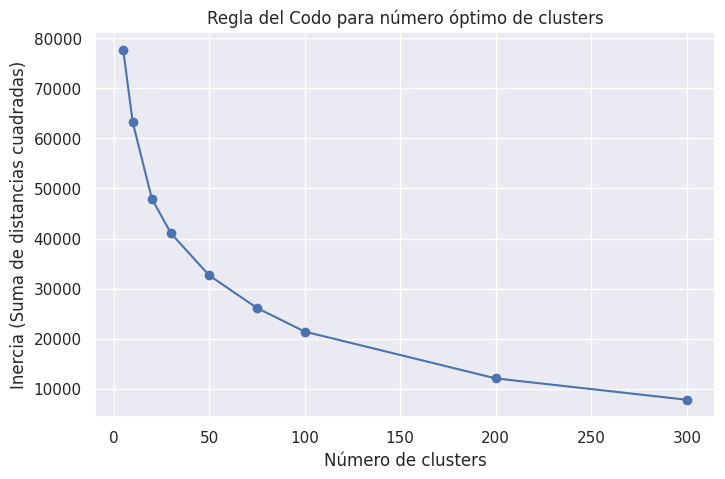

In [9]:
inertias = []
k_values = [5, 10, 20, 30, 50, 75, 100, 200, 300]

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(df_procesado)
    inertias.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertias, marker='o')
plt.title("Regla del Codo para número óptimo de clusters")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia (Suma de distancias cuadradas)")
plt.grid(True)
plt.show()


Al observar el gráfico resultante, se pueden obtener conclusiones sobre el número apropiado de clusters. La regla del codo sugiere elegir el número de clusters donde la reducción en la inercia se estabiliza significativamente. En otras palabras, se busca el punto en el gráfico donde la curva de inercia comienza a aplanarse o forma un codo.

## Reducción de Dimensionalidad

<img src="https://1000logos.net/wp-content/uploads/2020/11/Wine-Logo-old.png" width = "300" align="center"/>


Para este ejercicio utilizaremos el **Wine Dataset**, un conjunto de datos clásico disponible en la librería **scikit-learn** y en el repositorio de la **UCI Machine Learning**.
Este dataset contiene información de **178 muestras de vino** provenientes de la región italiana de *Piamonte*. Cada vino pertenece a una de **tres variedades de uva** (*clases*), que actúan como etiquetas para el análisis supervisado, pero aquí se usarán solo como referencia en la visualización.

Cada muestra está descrita por **13 variables químicas** obtenidas de un análisis de laboratorio, entre ellas:

* **Alcohol**: porcentaje de alcohol en el vino.
* **Malic acid**: concentración de ácido málico.
* **Ash**: contenido de ceniza.
* **Alcalinity of ash**: alcalinidad de la ceniza.
* **Magnesium**: cantidad de magnesio (mg/L).
* **Total phenols**: concentración total de fenoles.
* **Flavanoids**: tipo de fenoles con propiedades antioxidantes.
* **Nonflavanoid phenols**: fenoles que no son flavonoides.
* **Proanthocyanins**: compuestos relacionados con el color y el sabor.
* **Color intensity**: intensidad del color del vino.
* **Hue**: matiz del color.
* **OD280/OD315 of diluted wines**: relación de absorbancia que mide la calidad del vino.
* **Proline**: concentración de prolina (un aminoácido).

Estas características permiten representar cada vino como un punto en un espacio de **13 dimensiones**.

El objetivo del análisis con este dataset es **reducir la dimensionalidad** para visualizar y explorar patrones en los datos. Para ello aplicaremos:

* **PCA (Principal Component Analysis):** identificar las combinaciones lineales de variables que explican la mayor varianza en el conjunto.
* **t-SNE (t-distributed Stochastic Neighbor Embedding):** mapear las muestras a 2D o 3D, preservando relaciones de vecindad y estructuras no lineales.

La comparación entre ambas técnicas permitirá observar cómo las tres clases de vinos se diferencian en el espacio reducido y discutir la utilidad de la reducción de dimensionalidad en datos con mayor número de variables que en el caso del dataset *Wine*.



In [13]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [11]:
# cargar dataset
dataset = load_wine()

# nombres de las variables
features = dataset.feature_names
target = 'wine_class'

# construir DataFrame
wine = pd.DataFrame(dataset.data, columns=features)
wine[target] = dataset.target

# ver primeras filas
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0




### 1. **Análisis detallado con PCA**

* Calcular la **varianza explicada** por cada componente principal y representar el gráfico de varianza acumulada, identificando cuántos componentes son necesarios para capturar al menos el **90–95% de la información**.
* Construir tablas y gráficos que muestren cómo las observaciones (vinos) se proyectan en las primeras componentes principales.
* Analizar los **loadings** (coeficientes de cada variable en los componentes) e interpretar qué características químicas del vino (alcohol, fenoles, color, etc.) tienen mayor influencia en las nuevas dimensiones.
* Visualizar los datos reducidos a 2D o 3D e interpretar si las **tres variedades de vino** se separan de forma clara en el espacio proyectado.



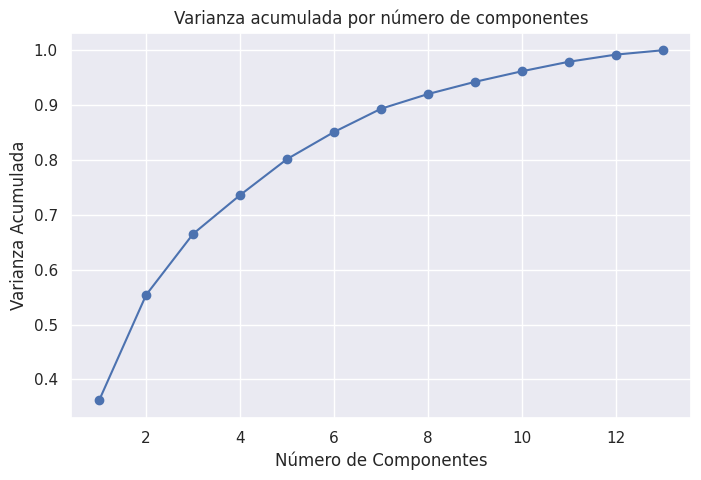

Se necesitan 10 componentes para explicar al menos el 95% de la varianza.

Tablas y gráficas que muestran como las observaciones poroyectan en las componenten principales:



,PC,var_exp,var_exp_acum
0,PC1,0.361988,0.361988
1,PC2,0.192075,0.554063
2,PC3,0.111236,0.665300
3,PC4,0.070690,0.735990
4,PC5,0.065633,0.801623
5,PC6,0.049358,0.850981
6,PC7,0.042387,0.893368
7,PC8,0.026807,0.920175
8,PC9,0.022222,0.942397
9,PC10,0.019300,0.961697


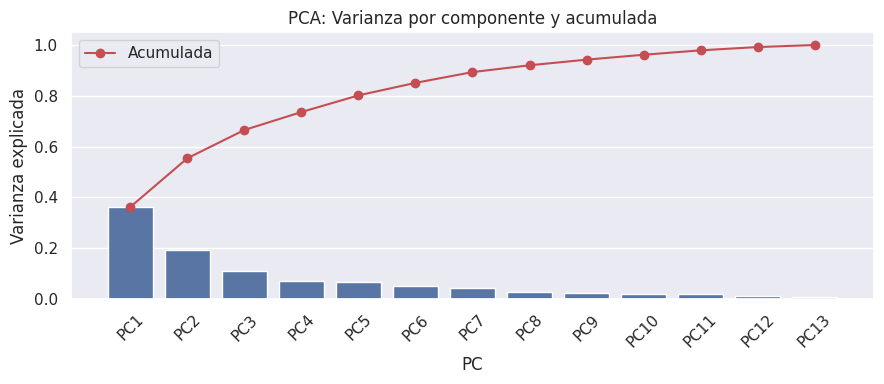

,PC1,PC2,PC3,wine_class
0,3.316751,1.443463,-0.165739,0
1,2.209465,-0.333393,-2.026457,0
2,2.516740,1.031151,0.982819,0
3,3.757066,2.756372,-0.176192,0
4,1.008908,0.869831,2.026688,0


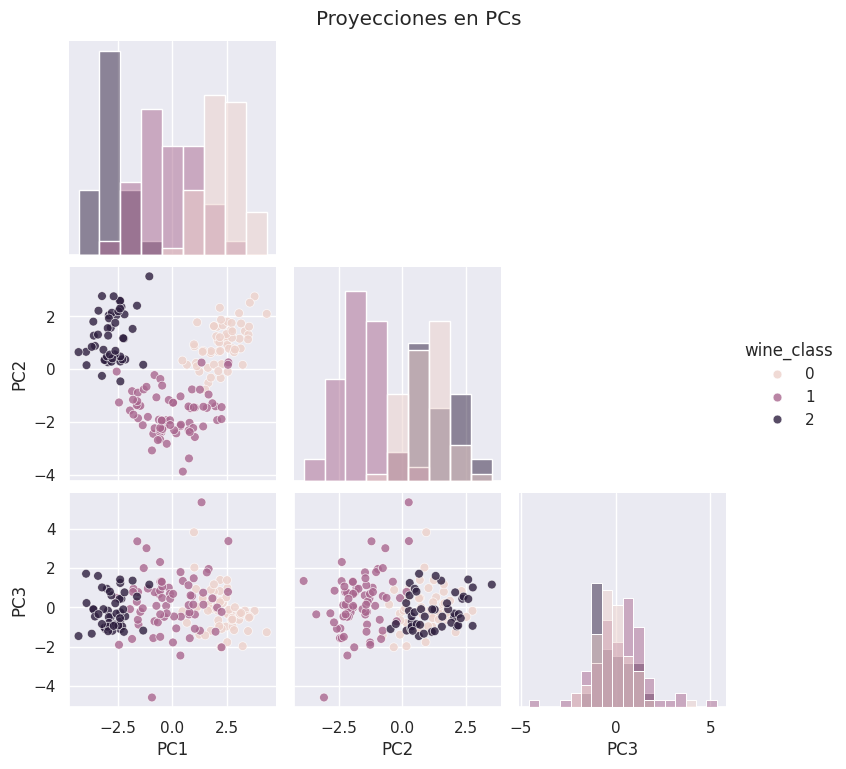


Loadings 5 PCs:


,PC1,PC2,PC3,PC4,PC5
alcohol,0.144,0.484,-0.207,-0.018,-0.266
malic_acid,-0.245,0.225,0.089,0.537,0.035
ash,-0.002,0.316,0.626,-0.214,-0.143
alcalinity_of_ash,-0.239,-0.011,0.612,0.061,0.066
magnesium,0.142,0.300,0.131,-0.352,0.727
total_phenols,0.395,0.065,0.146,0.198,-0.149
flavanoids,0.423,-0.003,0.151,0.152,-0.109
nonflavanoid_phenols,-0.299,0.029,0.170,-0.203,-0.501
proanthocyanins,0.313,0.039,0.149,0.399,0.137
color_intensity,-0.089,0.530,-0.137,0.066,-0.076



Visualización Datos reducidos:


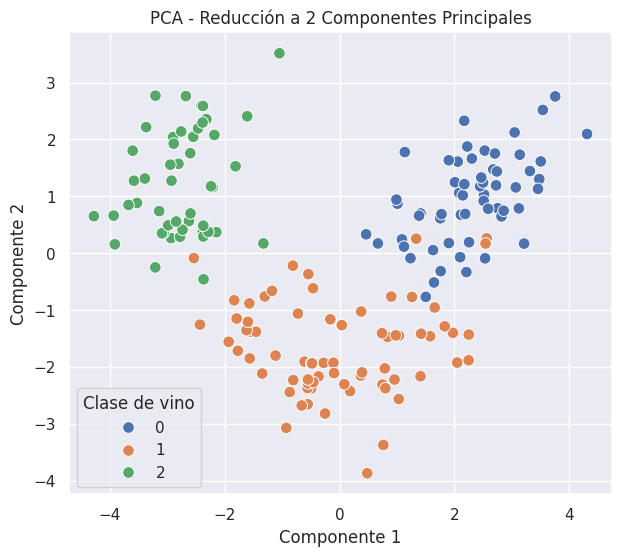

In [36]:
#estandarización de las variables
scaler = StandardScaler()
wine_scaled = scaler.fit_transform(wine[features])

#un ajuste del modelo PCA
pca = PCA()
wine_pca = pca.fit_transform(wine_scaled)

#varianza explicada por componente
var_exp = pca.explained_variance_ratio_
var_exp_acum = np.cumsum(var_exp)

#un vistazo con gráfico de varianza explicada acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_exp_acum)+1), var_exp_acum, marker='o')
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Acumulada")
plt.title("Varianza acumulada por número de componentes")
plt.grid(True)
plt.show()

#identificamos cuántas componentes capturan el 95% de la varianza
num_comp = np.argmax(var_exp_acum >= 0.95) + 1
print(f"Se necesitan {num_comp} componentes para explicar al menos el 95% de la varianza.\n")


#tablas y gráficos

print(f"Tablas y gráficas que muestran como las observaciones poroyectan en las componenten principales:\n")
var_tbl = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(var_exp))],
    "var_exp": var_exp,
    "var_exp_acum": var_exp_acum
})
display(var_tbl.head(10))


plt.figure(figsize=(9,4))
sns.barplot(x="PC", y="var_exp", data=var_tbl, color="C0")
plt.plot(range(len(var_exp_acum)), var_exp_acum, marker="o", color="C3", label="Acumulada")
plt.xticks(rotation=45)
plt.ylabel("Varianza explicada")
plt.title("PCA: Varianza por componente y acumulada")
plt.legend()
plt.tight_layout()
plt.show()

scores = pd.DataFrame(
    wine_pca[:, :3],
    columns=["PC1", "PC2", "PC3"],
    index=wine.index
)
scores["wine_class"] = wine["wine_class"].values
display(scores.head())

#añadimos un pairplot de las 3 primeras PCs
sns.pairplot(scores, vars=["PC1","PC2","PC3"], hue="wine_class", corner=True, diag_kind="hist", plot_kws={"s":40, "alpha":0.8})
plt.suptitle("Proyecciones en PCs", y=1.02)
plt.show()

#loadings
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=[f"PC{i+1}" for i in range(len(features))]
)

#tabla de loadings de las 5 primeras PCs
print("\nLoadings 5 PCs:")
display(loadings.iloc[:, :5].round(3))



#reducir a 2 componentes para visualización
pca_2 = PCA(n_components=2)
wine_pca_2d = pca_2.fit_transform(wine_scaled)



#visualización 2D

print("\nVisualización Datos reducidos:")
plt.figure(figsize=(7,6))
sns.scatterplot(x=wine_pca_2d[:,0], y=wine_pca_2d[:,1], hue=wine['wine_class'], palette='deep', s=70)
plt.title("PCA - Reducción a 2 Componentes Principales")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Clase de vino")
plt.show()

Los loadings muestran que flavanoids, total_phenols, OD280/OD315, y alcohol influyen más en la primera componente (PC1), mientras que malic_acid y magnesium destacan en la segunda (PC2). Estas variables representan las propiedades químicas más determinantes para diferenciar los vinos.

En la proyección 2D del PCA, las tres variedades de vino se separan claramente, con grupos bien definidos y poco solapamiento. Esto indica que las características químicas permiten distinguir eficazmente los tipos de vino y que el PCA logró una buena reducción dimensional conservando la mayor parte de la informaci



### 2. **Análisis detallado con t-SNE**

* Aplicar **t-SNE** para reducir los datos a 2 dimensiones, probando diferentes configuraciones de hiperparámetros como *perplexity* y *learning rate*.
* Comparar las distintas visualizaciones obtenidas y discutir cómo los hiperparámetros afectan la estructura de los clústeres.
* Analizar si las **tres clases de vinos** forman agrupaciones definidas y si t-SNE logra capturar relaciones no lineales que PCA no refleja.



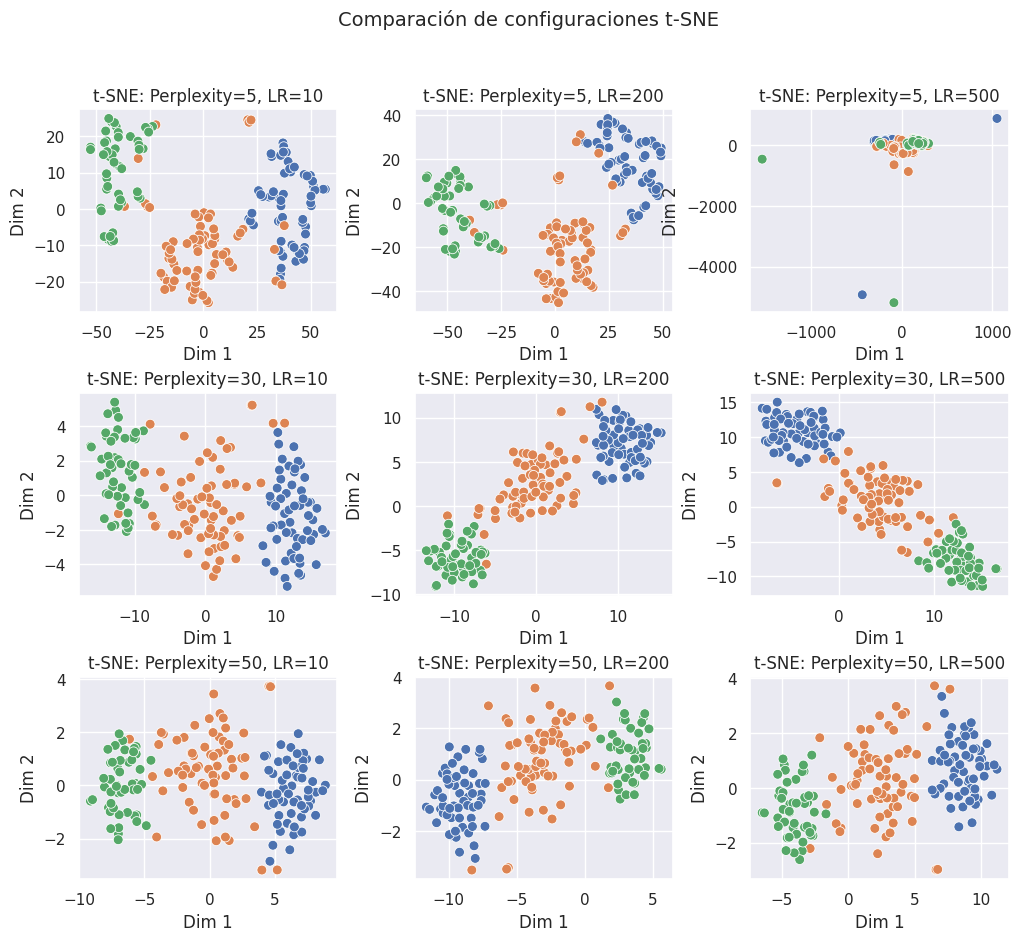

In [37]:
scaler = StandardScaler()
wine_scaled = scaler.fit_transform(wine[features])

# Probar diferentes combinaciones de hiperparámetros
perplexities = [5, 30, 50]
learning_rates = [10, 200, 500]

fig, axes = plt.subplots(len(perplexities), len(learning_rates), figsize=(12, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(n_components=2, perplexity=perp, learning_rate=lr, random_state=42)
        wine_tsne = tsne.fit_transform(wine_scaled)
        sns.scatterplot(
            x=wine_tsne[:, 0], y=wine_tsne[:, 1],
            hue=wine["wine_class"], palette="deep", s=50, ax=axes[i, j], legend=False
        )
        axes[i, j].set_title(f"t-SNE: Perplexity={perp}, LR={lr}")
        axes[i, j].set_xlabel("Dim 1")
        axes[i, j].set_ylabel("Dim 2")

plt.suptitle("Comparación de configuraciones t-SNE", fontsize=14)
plt.show()

El algoritmo t-SNE permitió proyectar los datos del vino en dos dimensiones, explorando distintas combinaciones de hiperparámetros.
Se observó que valores de perplexity entre 30 y 50 y una learning rate media (200) generaron las separaciones más estables y definidas entre las tres clases de vino.

A diferencia del PCA, que capta relaciones lineales, el t-SNE logró representar estructuras no lineales, revelando agrupamientos más compactos y márgenes más claros entre las clases. Las tres variedades de vino se distinguen nítidamente, lo que confirma que t-SNE captura diferencias más sutiles en la composición química de los vinos, difíciles de reflejar con técnicas lineales.



### 3. **Comparación entre PCA y t-SNE**

* Contrastar las visualizaciones y discutir las **ventajas y limitaciones** de cada técnica:

  * PCA como método **lineal** para interpretar varianza y relaciones globales.
  * t-SNE como método **no lineal** que preserva relaciones locales y vecindades.
* Evaluar en qué escenarios prácticos sería más recomendable usar PCA (interpretabilidad, reducción previa para modelos) o t-SNE (exploración y visualización de clústeres).
* Reflexionar sobre la **importancia de la reducción de dimensionalidad** en datasets de alta dimensión como Wine, destacando su utilidad para:

  * Visualizar patrones ocultos en los datos.
  * Reducir complejidad y ruido antes de aplicar algoritmos de aprendizaje automático.
  * Facilitar la interpretación y comunicación de resultados.



El PCA y el t-SNE mostraron enfoques complementarios para la reducción de dimensionalidad.
El PCA, al ser un método lineal, permitió interpretar la varianza global de los datos y determinar qué variables químicas tienen mayor influencia en la diferenciación de los vinos. Su ventaja principal es la interpretabilidad y utilidad como paso previo a modelos predictivos. Sin embargo, puede no capturar relaciones más complejas entre variables.

Por otro lado, t-SNE es un método no lineal que conserva mejor las relaciones locales, revelando agrupamientos más definidos y capturando patrones no visibles con PCA. Su desventaja es la menor interpretabilidad y sensibilidad a los hiperparámetros, lo que lo hace más adecuado para visualización exploratoria que para análisis explicativo.

 En conjunto, ambos métodos demuestran la importancia de la reducción de dimensionalidad: permiten simplificar los datos, eliminar ruido y visualizar patrones ocultos. Mientras el PCA ofrece una visión global e interpretable, el t-SNE brinda una perspectiva más detallada de las estructuras no lineales dentro del conjunto de vinos.